---
# GA DSI6 capstone project - Predicting song genres by their lyrics
### Oliver Sildmäe

---

### Content guide
- [Problem statement and goal](#intro)
- [Imports and settings](#imports)
- [Data setup and cleaning](#setup)
- [Exploratory data analysis](#eda)
- [Data transformations and related modeling](#modeling)
    - [Models with all (unbalanced) genre labels](#all)
    - [Models with under/oversampling](#overunder)
    - [Models with TFIDF](#tfidf)
    - [Models with consolidated style labels](#merged)
    - [Hyperparameter optimisation](#grid)
    - [Dimensionality reduction, clustering and Latent Dirichlet Allocation](#pca)
- [Conclusion](#theend)

<a id='intro'></a>

## Problem statement and goal

Genres are the primary way in which we categorise music. They identify music as belonging to a certain shared tradition or set of conventions, providing people with a rough idea of what to expecect from a song even before listening to it. This labeling is usually done by identifying how music 'sounds' - the instruments used, song running times, keys and tempos, etc.

Lyrics are generally very much secondary in this categorisation. Even though people have certain stereotypes about music of certain genres (e.g., Christian rock being largely about Jesus; punk about anarchy, or hip-hop using a lot of profanities and putting large emphasis on complex rhyming schemes), it seems uncertain that just by looking the lyrics of a song, one would be able to tell whether a song at hand belongs to, for example, the rock, pop or country genre, or something something completely different. Perhaps there are, however, common lyrical themes within these genres, ones that would be difficult to discern just by looking at individual songs?

This project attemtps to answer that question by using a large dataset of songs' lyrics and their respective genre labels, examining the possibility of predicting songs' genres based purely on their lyrical content. If successful, it would give insight into whether songs of a specific genre tend to have lyrics that significantly differentiate them for songs of other genres. Further, it would provide us with a comparative element of genre relatedness based on lyrics, as well as helping us identify which words (or the lack thereof) help define certain genres.

This will be a multiple classification problem, with each genre/style as a separte class within the dependent variable. The independent variables will be the bag-of-words format binary variables for the stemmed top 5000 words across all songs.

The data for this project comes from the below two auxiliary projects to The Million Song Dataset:<br>
Genres - http://www.ifs.tuwien.ac.at/mir/msd/download.html <br>
Lyrics - https://labrosa.ee.columbia.edu/millionsong/musixmatch

 <a id='imports'></a>

## Imports and settings

In [4]:
import pandas as pd
import numpy as np
import scipy as sp
import time
import sqlite3

from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer
from sklearn.decomposition import PCA, LatentDirichletAllocation
from sklearn.neural_network import MLPClassifier

from wordcloud import WordCloud
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler
from xgboost import XGBClassifier

import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

 <a id='setup'></a>

## Data set-up and cleaning

The main goal here is to merge the two datasets, using their shared song ID-s to match genres and lyrics, and set the data up for exploratory data analyses and modeling.

#### Creating a dataframe containing information about genres from the .cls file (download link above)

In [2]:
# Open the .cls word file containing genres data
with open('./msd-MASD-styleAssignment.cls') as f:
    lines = f.readlines()   

# Separate the read-in single string data to song ID-s and genre labels   
genre = pd.DataFrame(lines)   
genre['song_id'] = genre[0].apply(lambda x: x.split("\t")[0])
genre['genre'] = genre[0].apply(lambda x: x.split('\t')[1].split('\n')[0])
genre.drop([0], axis = 1, inplace = True)

#### Connecting to the lyrics SQLite database (download link above), creating a temporary table based on the Genres dateframe above

In [3]:
# Establish connection to the lyrics SQL database
conn = sqlite3.connect('mxm_dataset.db') 
c = conn.cursor()

# Set the number of rows that will be matched on
test = pd.DataFrame(genre)
#test = pd.DataFrame(genre.song_id[0:100000]) # for a subset of e.g. 200k songs

# Write the genres dataframe to a'tmp' table in the SQL database. This will be matched on below
test.to_sql('tmp', conn, if_exists='replace')

#### Create a genres and bag-of-words lyrics dataframe by combining the above two on their common song ID-s

In [4]:
# Get the long format data, joining so that only tracks that have genres and lyrics are included
res = c.execute("""SELECT l.track_id, l.word, 
                       CASE 
                           WHEN l.count > 0 THEN 1
                           ELSE 0
                        END
                   FROM lyrics l
                       JOIN tmp t ON l.track_id = t.song_id""")
                   # For Tfidftransformer used later on, set the 'THEN' clause to l.count
    
test_data = res.fetchall()

# Turn the long format data into a pandas dataframe, pivoting on lyrics (words)
test_df_long = pd.DataFrame(test_data, columns = ['song_id', 'word', 'count'])
test_df = test_df_long.pivot_table(index='song_id',columns='word')
test_df.columns = test_df.columns.get_level_values(1)
test_df.fillna(0, inplace = True);

#### Setting up the Y and X, performing a test-train split

In [5]:
# Set song_id as index for the genres dataframe
genre.set_index(genre.song_id, drop = True, inplace = True)
genre.drop('song_id', axis = 1, inplace = True)

# Merge genres and lyrics dataframes together, extract Y from it
Y_big = genre.merge(test_df, how = 'inner', left_on = genre.index, right_on = test_df.index)
Y_big.set_index('key_0', drop = True, inplace = True)
Y_string = Y_big.copy().pop('genre')

In [ ]:
# Converting the genre labels from string to integers starting at 0
le = LabelEncoder()
le.fit(['Punk', 'Pop_Indie', 'Hip_Hop_Rap', 'Country_Traditional', 'Pop_Contemporary', 
        'Rock_Alternative', 'Rock_College', 'Rock_Contemporary', 'Experimental', 'Metal_Alternative',
        'RnB_Soul', 'Reggae', 'Folk_International', 'Pop_Latin', 'Metal_Heavy', 'Rock_Neo_Psychedelia',
        'Grunge_Emo', 'Rock_Hard', 'Gospel', 'Electronica', 'Metal_Death', 'Jazz_Classic', 'Dance', 
        'Blues_Contemporary', 'Big_Band'])
y = le.transform(Y_string)
x = test_df.copy().reset_index(drop = True)

In [7]:
# Create a train-test split with a test size of 25%, shuffling the data and stratifying y
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.25, shuffle = True, stratify = y)

#### Close database connection and purge unused variables from memory

In [8]:
# Close DB connection
conn.close();

# Purge variables that we're done with
del genre, lines, res, test, test_data, test_df, test_df_long, Y_big, Y_string, x, y

 <a id='eda'></a>

## Exploratory data analysis

#### A look at the X and Y I will be working with

In [5]:
x_train.head(2)

,Unnamed: 0,&,000,1,10,100,12,13,15,16,...,è,é,él,és,était,être,ô,über,–,‘caus
0,5359,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,81259,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
print(f'Shape of x_train: {x_train.shape}')
print(f'Shape of y_train: {y_train.shape}')

Shape of x_train: (78336, 5000)
Shape of y_train: (78336,)


The training X dataframe is left with 78336 songs (rows) after joining the genres and lyrics data, and it has the top 5000 most frequent words across all songs for columns. The columns are binary, simply indicating whether a given word is present in the song's lyrics or not.<br><br>
The dependent variable has 25 possible categories (genres), the distribution of which can be seen in the below graph.
<br><br>
A quarter of the data has been set aside for testing.

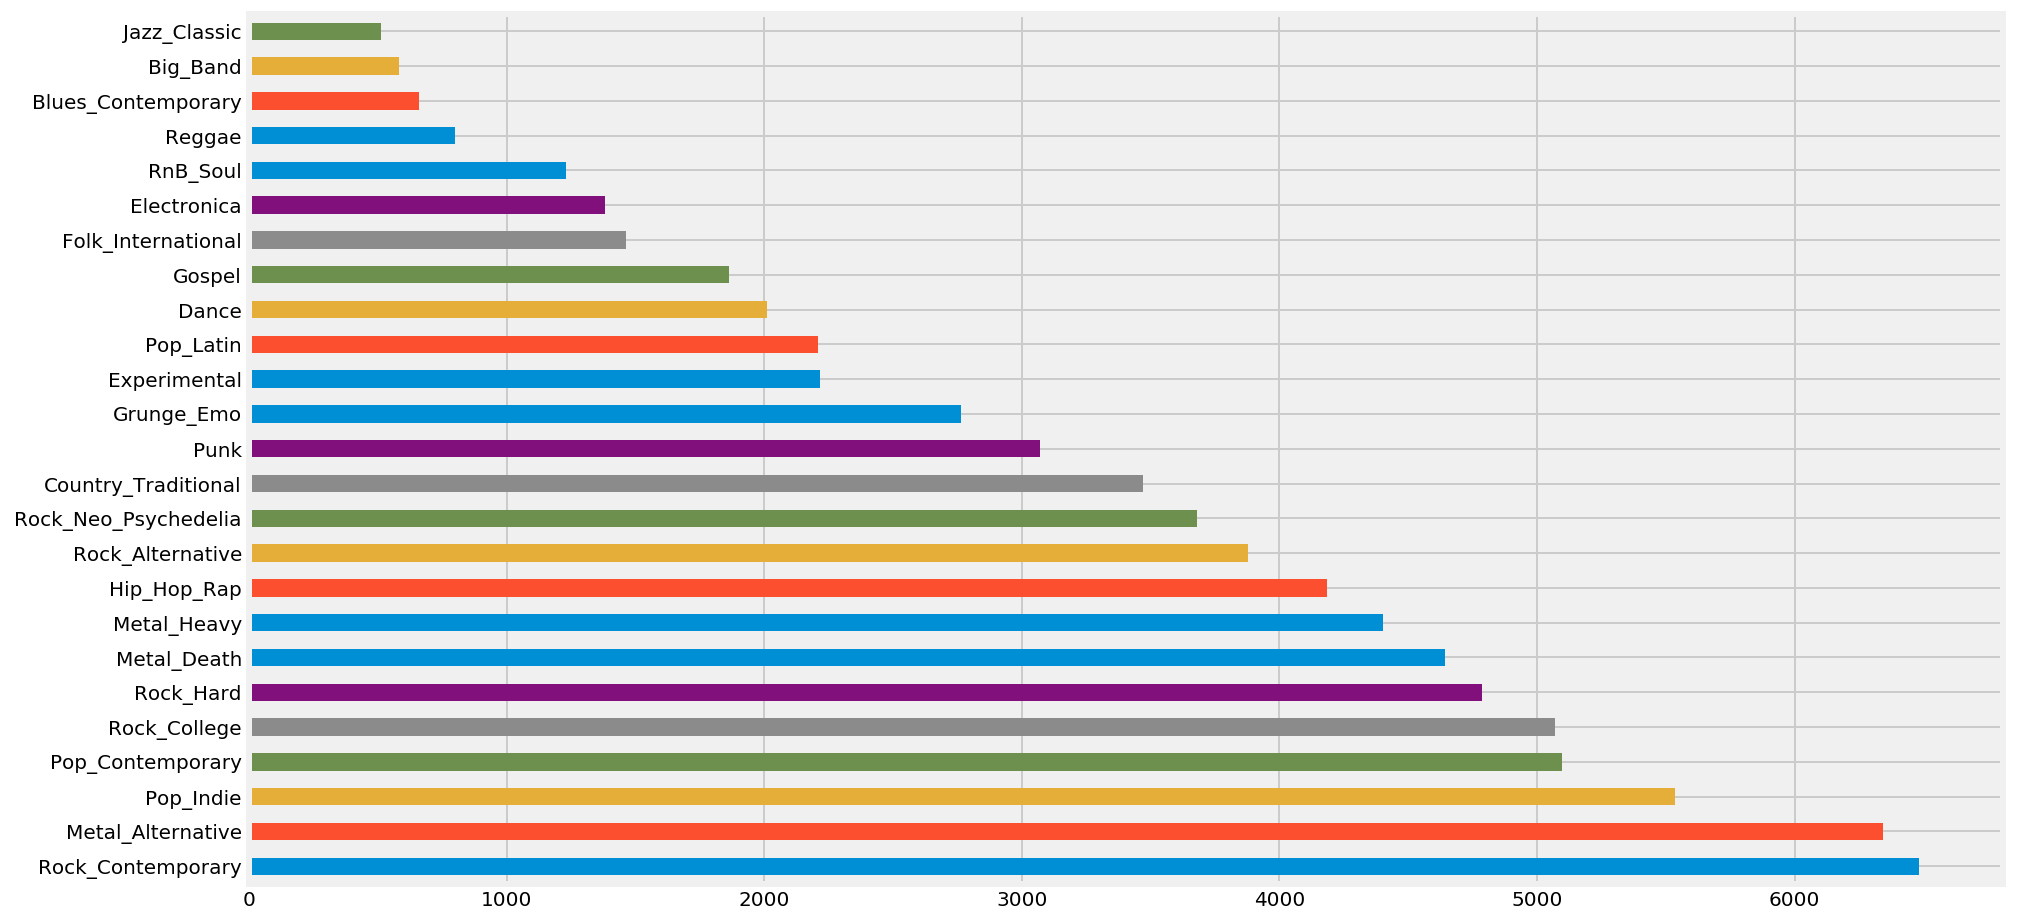

In [11]:
plt.figure(figsize=(14,8))
pd.Series(y_train).value_counts().plot(kind='barh')
plt.yticks(list(range(25)),
           list(reversed(
               le.inverse_transform([10,0,1,18,19,4,6,7,3,16,5,8,17,2,24,20,9,13,12,23,21,14,15,11,22]))))
plt.show();

The style labels in the dataset seem to be rather unevenly split - for example, there are far more songs that have various metal, rock or pop labels than there are classical, jazz or big band songs. 
<br>
<br>
If not countered with over- and/or undersampling, the models built will be biased towards these oft-occurring genres, rarely predicting the styles which appear less frequently. It's an interesting question whether the above distribution reflects reasonably well what we expect an average sample of random songs to be, and therefore whether this imbalance is a a serious issue. 
<br>
<br>
The underlying track selection for the Million Song Dataset comes from The Echo Nest, a music intelligence and data platform founded in 2005. The genre/style data comes from All Music Guide, an online music guide launched in 1991. As both of these website primarily focus on contemporary music, the dataset is very likely biased towards music from the past 20-30 years. This isn't necessarily an issue though, as we expect the the model to be used primarily in the context of contemporary music.
<br>
<br>
Further, certain genres like hip-hop/rap and R&B seem to be very under-represented. Despite these two genres combined accounting for about a quarter of US music consumption in 2017 (https://www.nielsen.com/us/en/insights/reports/2018/2017-music-us-year-end-report.html), they account for less than 7% of the dataset at hand. Thus, we assume the model to be somewhat disproportionately undertuned to predicting for example hip-hop/rap/R&B music, instead making more predictions for rock, metal and pop songs.
<br>
<br>
Finally, there is also the more general issue that genres are inherently rather arbitrary, with a lot of cross-over between various genres. Therefore, for many songs, the 'real' genre they belong to can be very hard to pin down, and we're here relying purely on the labels attributed at by All Music Guide. Also, in case of these borderline cases, although we might be partially right (or wrong), the models will be making a single classification.

#### Removing stopwords and some ofter common words to get an idea of the words that define various genres

In [21]:
# Getting stopwords from TfidVectorizer and append to it my personal stop-words
tvec = TfidfVectorizer(stop_words='english')
stopwords = list(tvec.get_stop_words())
ignore_extra = ['know', 'just', 'like','Unnamed: 0', 'say']
for word in ignore_extra:
    stopwords.append(word)

# Join Y back on the stop-word filtered X to be able to target specific categories below    
joint_df = x_train.copy()
joint_df = joint_df[[col for col in joint_df.columns if col not in stopwords]]
joint_df['style_label'] = y_train.copy()

#### Death metal lyrical profile

In [43]:
# Subset on the genre we're interested in
words = []
counts = []
joint_df_subset = joint_df[joint_df.style_label==12].drop('style_label', axis=1)

# Update the word name and related counts
for column in joint_df_subset:
    words.append(column)
    counts.append(joint_df_subset[column].sum())
    
word_counts = pd.DataFrame(np.column_stack([counts, words]), columns = ['frequency', 'word'])
word_counts.set_index('word', inplace=True, drop=True)
word_counts.frequency = word_counts.frequency.astype(float)
words_counts_sorted_subset = word_counts.sort_values('frequency', ascending = False)

print('Top 15 words')
print(words_counts_sorted_subset.head(15))

Top 15 words
       frequency
word            
life      1478.0
time      1355.0
eye       1256.0
come      1201.0
die       1158.0
world     1067.0
death     1059.0
soul      1005.0
blood      975.0
live       956.0
way        937.0
mind       922.0
dead       921.0
pain       916.0
feel       912.0


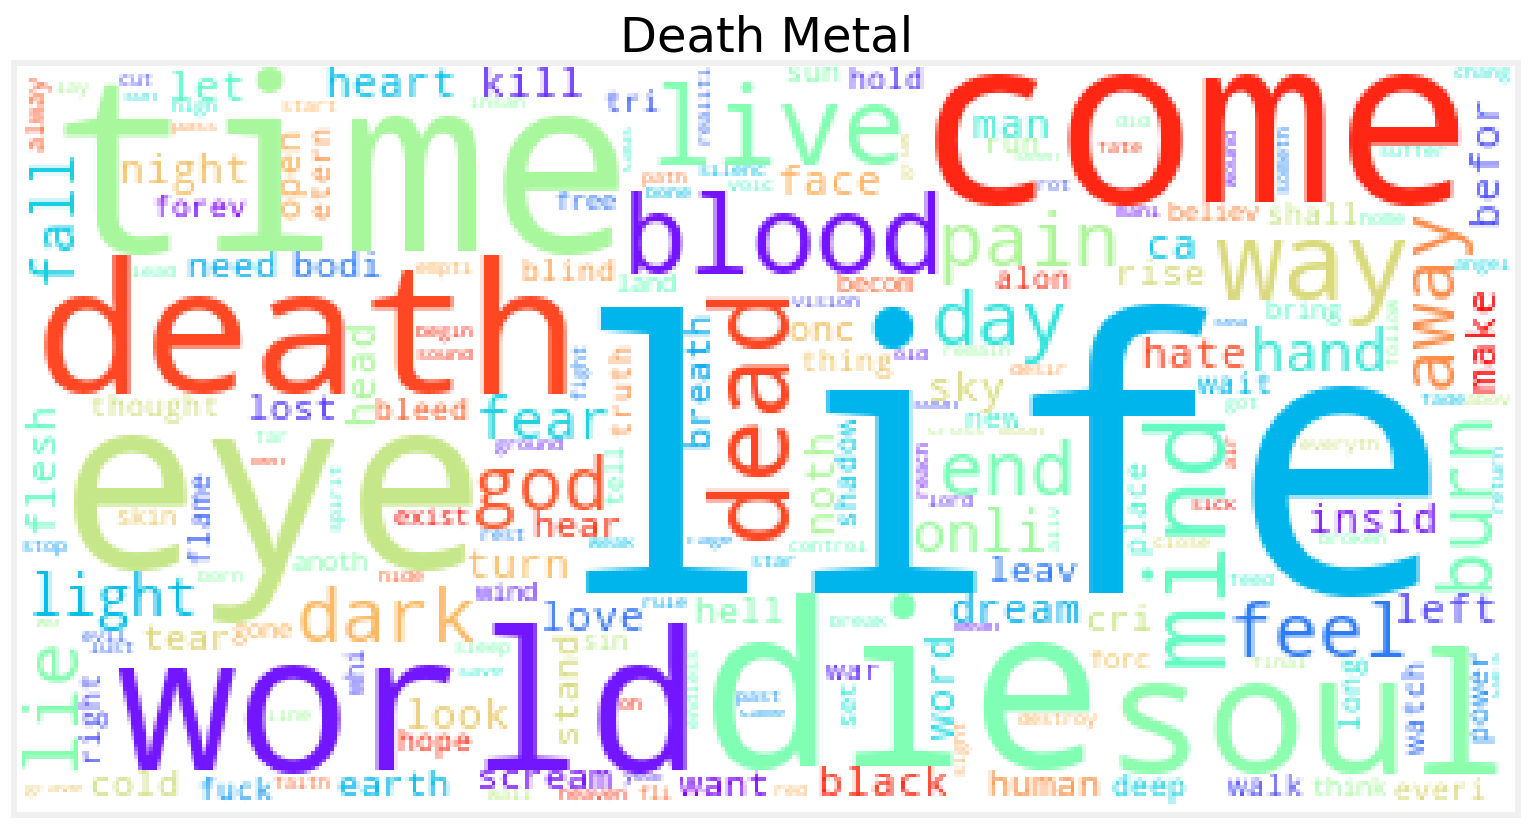

In [44]:
# Create a word cloud using the above word count dataframe
wc_gen = {}
wc = WordCloud(mode='RGBA',background_color='white',colormap='rainbow',random_state=2)

fig, ax = plt.subplots(figsize=(12,40))

wc_gen = wc.generate_from_frequencies(dict(words_counts_sorted_subset.reset_index().values))
ax.imshow(wc_gen)
ax.set_title('Death Metal',fontsize=24)
ax.set_xticks([])
ax.set_yticks([])

plt.show()

#### Gospel  lyrical profile

In [45]:
# Subset on the genre we're interested in
words = []
counts = []
joint_df_subset = joint_df[joint_df.style_label==7].drop('style_label', axis=1)

# Update the word name and related counts
for column in joint_df_subset:
    words.append(column)
    counts.append(joint_df_subset[column].sum())
    
word_counts = pd.DataFrame(np.column_stack([counts, words]), columns = ['frequency', 'word'])
word_counts.set_index('word', inplace=True, drop=True)
word_counts.frequency = word_counts.frequency.astype(float)
words_counts_sorted_subset = word_counts.sort_values('frequency', ascending = False)

print('Top 15 words')
print(words_counts_sorted_subset.head(15))

Top 15 words
        frequency
word             
love        941.0
come        715.0
heart       685.0
life        683.0
time        589.0
way         533.0
god         514.0
let         514.0
lord        507.0
day         499.0
need        494.0
oh          488.0
make        475.0
chorus      463.0
world       460.0


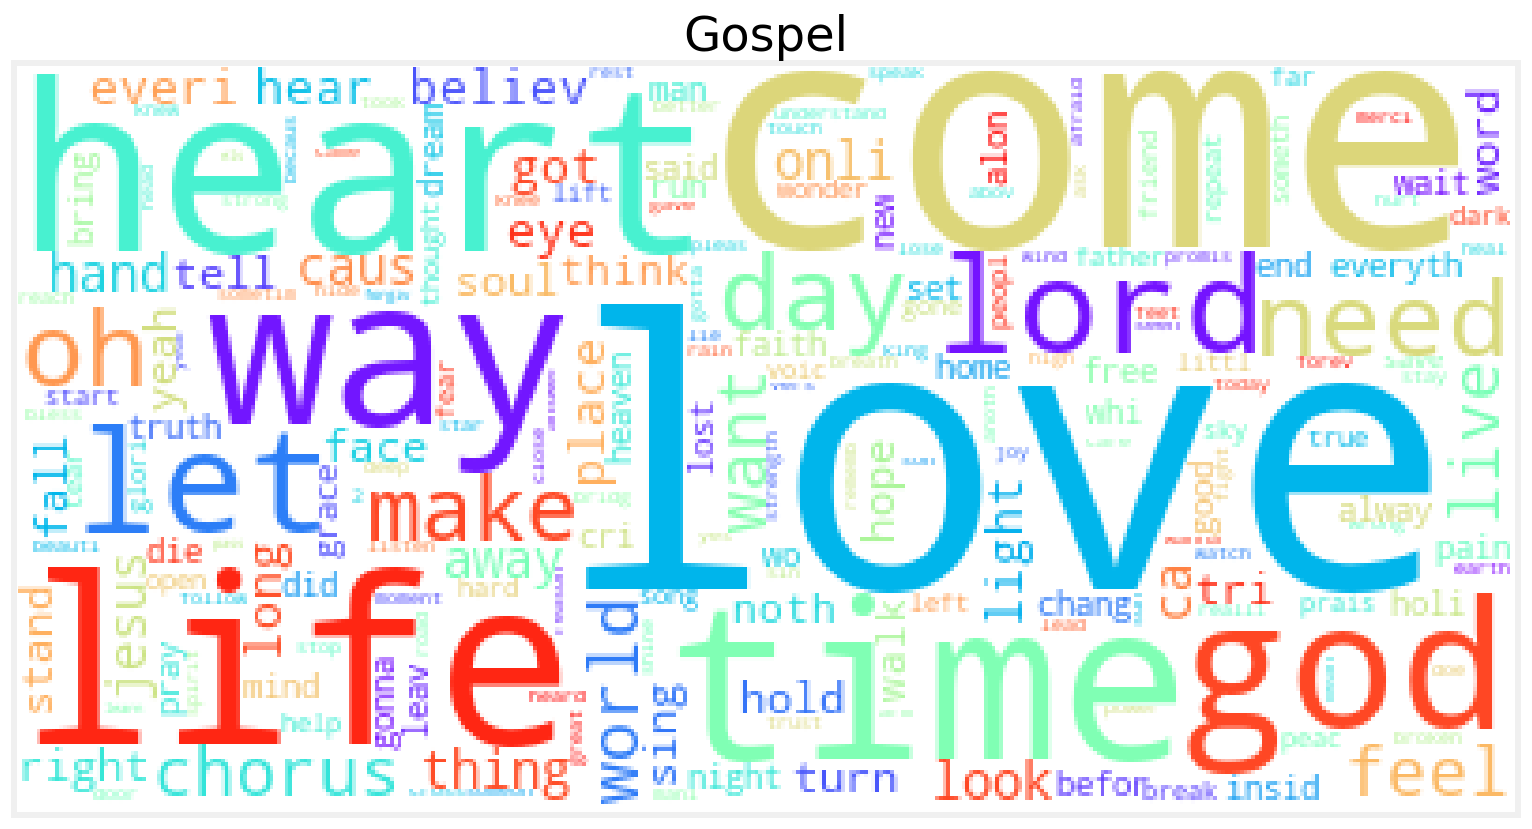

In [47]:
# Create a word cloud using the above word count dataframe
wc_gen = {}
wc = WordCloud(mode='RGBA',background_color='white',colormap='rainbow',random_state=2)

fig, ax = plt.subplots(figsize=(12,40))

wc_gen = wc.generate_from_frequencies(dict(words_counts_sorted_subset.reset_index().values))
ax.imshow(wc_gen)
ax.set_title('Gospel',fontsize=24)
ax.set_xticks([])
ax.set_yticks([])

plt.show()

Once stop-words are removed, the expectation of what the lyrics for death metal and gospel music ought to be hold largely true. Death metal lyrics focus largely on death and mortality, with words like 'blood', 'soul', 'pain' and 'death' standing out as oft-occuring themes. Conversely, for gospel music, words such as 'love', 'lord', 'heart' and 'god' are among the most often encountered ones. There are also common shared themes like 'life' and 'time'.<br><br>
This is reassuring, as it will be these lyrical stereotypes which will help our models attribute the correct genres to songs.

#### Checking whether Zipf's law for the word frequency distribution holds

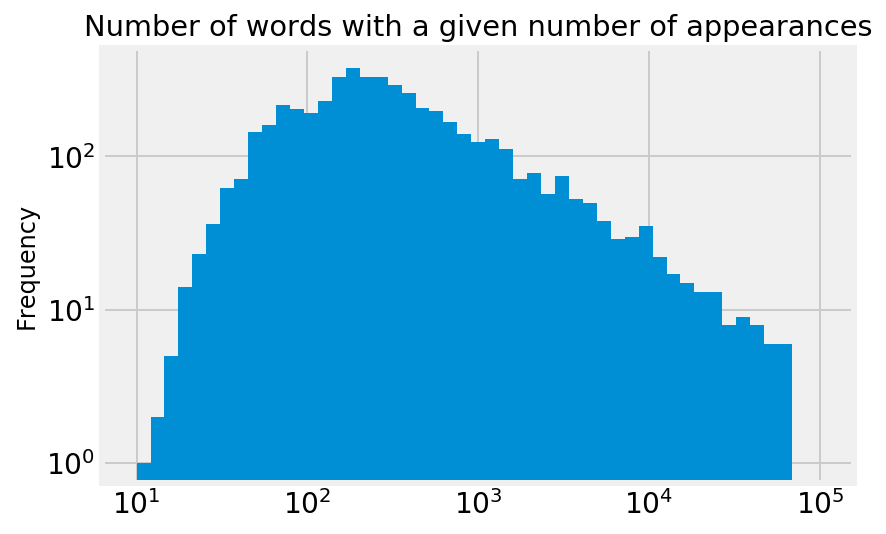

In [53]:
words = []
counts = []

# Update the word name and related counts (across all genres)
for column in x_train:
    words.append(column)
    counts.append(x_train[column].sum())

word_counts = pd.DataFrame(np.column_stack([counts, words]), columns = ['frequency', 'word'])
word_counts.set_index('word', inplace=True, drop=True)
word_counts.frequency = word_counts.frequency.astype(float)
words_counts_sorted = word_counts.sort_values('frequency', ascending = False)

# Plot a histogram of word count frequencies
words_counts_sorted.frequency.plot(kind='hist',
                                  bins=np.logspace(1,5,50),
                                  loglog=True,
                                  title='Number of words with a given number of appearances',
                                  fontsize=14)
plt.show()

Zipf's law states that given some corpus of natural language utterances, the frequency of any word is inversely proportional to its rank in the frequency table. Here, however we clearly don't observe this expected downwards trend, instead seeing something similar to a parabolic arch. This is likely due to the dataset having the top 5000 lyrics across all songs. If we had access to all lyrics, we would likely observe the highest frequency on the left-hand side, continually decreasing to the right, as there would be many words which only occur a very few times.

<a id='modeling'></a>

## Data transformations and related modeling

<a id='all'></a>

### Models with all (unbalanced) genre labels

##### Baseline

In [9]:
print(f'Baseline accuracy: {(round(len(y_train[y_train==22])/len(y_train), 4))}')

Baseline accuracy: 0.0828


The baseline, where we would always predict the most popular class, contemporary rock, is about 0.083

In [11]:
# Converting the train and test dataframes to sparse matrices for model building speed
x_train_sparse = sp.sparse.csr_matrix(x_train.values)
x_test_sparse = sp.sparse.csr_matrix(x_test.values)

Below, a number of different classifiers will be tested. As many models' performance is highly dependent on using an appropriate set of hyperparameters, these parameters will for all models here be gridsearched and cross-validated using GridSearchCV.

For each of the models, the parameters to be gridsearched will be outlined under the 'params' variable, with each key in the dictionary standing for the parameter to be tuned, and the values simply being the values that will be used for these parameters.

##### Logistic Regression

In [12]:
start_time = time.time()

model = LogisticRegression()

# setup the grid search
params = {'C':np.logspace(-3,3,20)}

gs = GridSearchCV(estimator=model,
                  param_grid=params,
                  cv=3,
                  scoring='accuracy',
                  return_train_score=True,
                  n_jobs = -1)

gs.fit(x_train_sparse, y_train)

# extract the grid search results
print('Best Parameters:')
print(gs.best_params_)
print('Best estimator mean cross validated training score:')
print(gs.best_score_)
print('Best estimator score on the full training set:')
print(gs.score(x_train_sparse, y_train))
print('Best estimator score on the test set:')
print(gs.score(x_test_sparse, y_test))
print(f'Time elapsed: {round((time.time() - start_time)/60)} minutes')

Best Parameters:
{'C': 0.018329807108324356}
Best estimator mean cross validated training score:
0.2830244076797386
Best estimator score on the full training set:
0.3725107230392157
Best estimator score on the test set:
0.29311071114004517
Time elapsed: 147 minutes


##### Random Forest

In [16]:
start_time = time.time()

model = RandomForestClassifier()

# setup the grid search
params = {'n_estimators': [10, 50, 100],
        'criterion': ['gini', 'entropy'],
        'max_depth':[5, 10, None],
        'min_samples_leaf': [1, 2]
        }

gs = GridSearchCV(estimator=model,
                  param_grid=params,
                  cv=3,
                  scoring='accuracy',
                  return_train_score=True,
                  n_jobs = -1)

gs.fit(x_train_sparse, y_train)

# extract the grid search results
print('Best Parameters:')
print(gs.best_params_)
print('Best estimator mean cross validated training score:')
print(gs.best_score_)
print('Best estimator score on the full training set:')
print(gs.score(x_train_sparse, y_train))
print('Best estimator score on the test set:')
print(gs.score(x_test_sparse, y_test))
print(f'Time elapsed: {round((time.time() - start_time)/60)} minutes')

Best Parameters:
{'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 2, 'n_estimators': 100}
Best estimator mean cross validated training score:
0.24410232843137256
Best estimator score on the full training set:
0.9657756331699346
Best estimator score on the test set:
0.2509095086738406
Time elapsed: 23 minutes


##### Adaboost

In [14]:
start_time = time.time()

model = AdaBoostClassifier()

# setup the grid search
params = {
         'n_estimators':[50, 100, 1000],
         'learning_rate':[0.8, 1.0]
         }

gs = GridSearchCV(estimator=model,
                  param_grid=params,
                  cv=3,
                  scoring='accuracy',
                  return_train_score=True,
                  n_jobs = -1)

gs.fit(x_train_sparse, y_train)

# extract the grid search results
print('Best Parameters:')
print(gs.best_params_)
print('Best estimator mean cross validated training score:')
print(gs.best_score_)
print('Best estimator score on the full training set:')
print(gs.score(x_train_sparse, y_train))
print('Best estimator score on the test set:')
print(gs.score(x_test_sparse, y_test))
print(f'Time elapsed: {round((time.time() - start_time)/60)} minutes')

Best Parameters:
{'learning_rate': 0.8, 'n_estimators': 100}
Best estimator mean cross validated training score:
0.2034952001633987
Best estimator score on the full training set:
0.21835426879084968
Best estimator score on the test set:
0.21701834335388503
Time elapsed: 3 minutes


##### XGBoost

In [13]:
start_time = time.time()

model = XGBClassifier()

# setup the grid search
params = {
        'learning_rate':[0.1, 0.3],
        'min_child_weight':[1, 5, 10],
        'max_depth':[3, 5, 10, 20]
        }

gs = GridSearchCV(estimator=model,
                  param_grid=params,
                  cv=3,
                  scoring='accuracy',
                  return_train_score=True,
                  n_jobs = -1)

gs.fit(x_train_sparse, y_train)

# extract the grid search results
print('Best Parameters:')
print(gs.best_params_)
print('Best estimator mean cross validated training score:')
print(gs.best_score_)
print('Best estimator score on the full training set:')
print(gs.score(x_train_sparse, y_train))
print('Best estimator score on the test set:')
print(gs.score(x_test_sparse, y_test))
print(f'Time elapsed: {round((time.time() - start_time)/60)} minutes')

Best Parameters:
{'learning_rate': 0.1, 'max_depth': 20, 'min_child_weight': 10}
Best estimator mean cross validated training score:
0.2711014093137255
Best estimator score on the full training set:
0.7503191380718954
Best estimator score on the test set:
0.278099031133918
Time elapsed: 214 minutes


##### Neural networks: multi-layer perceptron classifier

In [17]:
start_time = time.time()

model = MLPClassifier()

# setup the grid search
params = {
        'hidden_layer_sizes': [(50,50), (100,)],
        'activation': ['tanh', 'relu'],
        'solver': ['sgd', 'adam'],
        'alpha': [0.0001, 0.05]
        }

gs = GridSearchCV(estimator=model,
                  param_grid=params,
                  cv=3,
                  scoring='accuracy',
                  return_train_score=True,
                  n_jobs = -1)

gs.fit(x_train_sparse, y_train)

# extract the grid search results
print('Best Parameters:')
print(gs.best_params_)
print('Best estimator mean cross validated training score:')
print(gs.best_score_)
print('Best estimator score on the full training set:')
print(gs.score(x_train_sparse, y_train))
print('Best estimator score on the test set:')
print(gs.score(x_test_sparse, y_test))
print(f'Time elapsed: {round((time.time() - start_time)/60)} minutes')

C:\Users\olive\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Best Parameters:
{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (100,), 'solver': 'sgd'}
Best estimator mean cross validated training score:
0.2749183006535948
Best estimator score on the full training set:
0.43829146241830064
Best estimator score on the test set:
0.28085627848198214
Time elapsed: 336 minutes


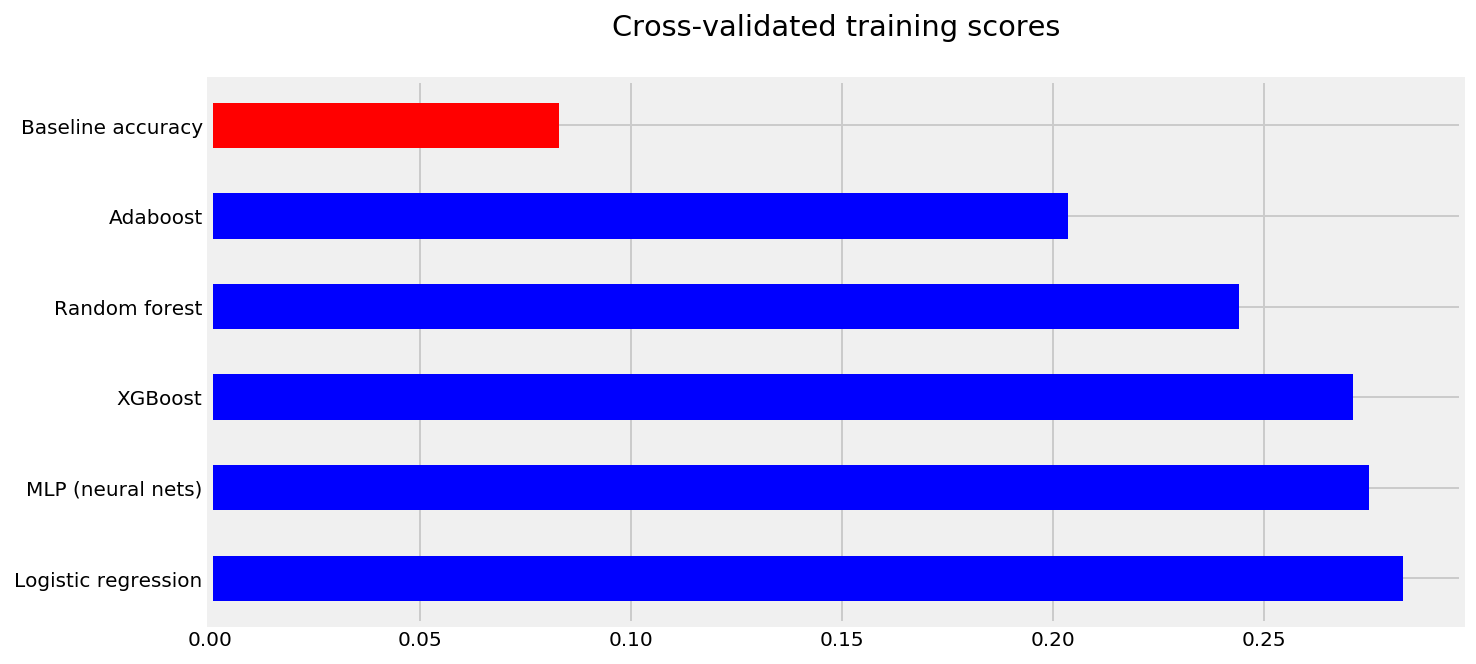

In [65]:
# Note: the creation of the 'scores_df' dataframe has been omitted here
scores_df.Score.plot(kind='barh', 
                     figsize=(10, 5),
                     title= 'Cross-validated training scores\n', 
                     color = ['b', 'b', 'b', 'b', 'b', 'r']);

<br>
Judging based on the cross-validated training scores, logistic regression seems to be the winner here, and will be the primary model used going forward. It is, however, possible that the MLP or XGBoost classifiers' performances could be still improved on by more extensive hyperparameter optimisation.

Although the best cross-validated training score of about 0.283 means that the model will in this case make a right prediction only just more than a quarter of the times, it is important to bear in mind that there are 25 labels (genres) in this classification problem. With the baseline being just over 0.08, the score of 0.283 is therefore nevertheless a significant improvement in prediction accuracy. 

Looking at the genre labels, it is immediately clear that certain genres are more similar to one another than others. For instance, rock  music is broken down into five sub-genres and metal into three sub-genres, whereas rap/hip-hop is simply a single label. It is arguably more 'forgivable' to make mis-classifications of similar sub-genres than it is to make mis-classifications for a genre that is completely dissimilar. For example, mistaking alternative rock music for contemporary rock music is far less severe of a mistake than mistaking it for electronica or grunge music would.

It is therefore important to look at the confusion matrix, as well as the precision and recall scores, to see where the misclassifications are being made.
<br><br>

#### Classification report and confusion matrix for the logistic regression above

In [113]:
# Classification report based on predicted values using the best logistic regression model from above
genre_labels = le.inverse_transform(list(range(25)))

y_pred = model.predict(x_test)
print(classification_report(y_test, y_pred, target_names=genre_labels))

                      precision    recall  f1-score   support

            Big_Band       0.15      0.12      0.14       193
  Blues_Contemporary       0.27      0.25      0.26       219
 Country_Traditional       0.37      0.41      0.39      1157
               Dance       0.12      0.09      0.10       671
         Electronica       0.07      0.05      0.06       460
        Experimental       0.13      0.09      0.11       739
  Folk_International       0.32      0.27      0.29       487
              Gospel       0.40      0.44      0.42       621
          Grunge_Emo       0.18      0.16      0.17       921
         Hip_Hop_Rap       0.62      0.60      0.61      1395
        Jazz_Classic       0.16      0.12      0.13       171
   Metal_Alternative       0.23      0.29      0.26      2114
         Metal_Death       0.45      0.54      0.49      1548
         Metal_Heavy       0.22      0.20      0.21      1468
    Pop_Contemporary       0.23      0.24      0.23      1699
       

Precision and recall vary a lot across the genres. The two genres that stand out the clearest are, unsurprisingly, hip-hop/rap and Latin pop. The former is likely to be driven by more common use of slang and profanities, whereas most of the songs in the Latin pop genre have spanish lyrics.

In [119]:
# Save the precision score for comparison later

# Get precision scores
precision_score_1 = precision_score(y_test, y_pred, average = None)
precision_score_1.shape = [25,1]
scores_df = pd.DataFrame(precision_score_1, columns = ['precision_score'])
scores_df.index = genre_labels

In [120]:
# Save the recall scores for comparison later
recall_score_1 = recall_score(y_test, y_pred, average = None)
recall_score_1.shape = [25,1]

scores_df['recall_score'] = recall_score_1

In [ ]:
# Create a confusion matrix for the above logistic regression model
confusion = pd.DataFrame(confusion_matrix(y_test, y_pred), 
                         index = le.inverse_transform(list(range(25))), 
                         columns = le.inverse_transform(list(range(25))))
# Save the confusion matrix to a .csv file. For ease of use, see coloured in version below
confusion.to_csv('confusion.csv', sep=',')

![title](confusion_pic.png)

In the colour-coded confusion matrix, the colours schemes are per each column (genre), indicating to which class the predictions were made. One would ideally hope to see a diagonal downwards red line surrounded by green, indicating that the correct predictions have been made for each class, with little or no misclassifications.<br>

The results here are rather reassuring, as the red/orange diagonal can clearly be seen. What stands out is the orange zone in the bottom-right corner, indicating that various rock genres do indeed seem get mixed up a lot with one another. Could consider addressing that by resampling and merging/consolidating these potentially very similar labels.

<a id='overunder'></a>

### Models with under/oversampling

As discussed above in the EDA section, is it unlikely that the data genre label distribution reflects that of the true world. It could therefore be informative to create models less biased towards the most popular genres in the database by resampling the data.<br><br>
Although this will almost certainly bring down the overall model accuracy for the test dat, it would help create a models which are more sensitive to the genres that are less represented in the database.

##### Undersampling

In [11]:
sampler = RandomUnderSampler(random_state = 1)
x_train_us, y_train_us = sampler.fit_sample(x_train, y_train)

In [12]:
start_time = time.time()
model = LogisticRegression()
model.fit(x_train_us, y_train_us)

print('Logistic regression:')
print(f'Cross-val. train score: {cross_val_score(model, x_train_us, y_train_us, cv=3, n_jobs=-1).mean()}')
print(f'Test score: {round(model.score(x_test, y_test), 4)}')
print(f'Time elapsed: {round((time.time() - start_time), 1)} seconds')

Logistic regression:
Cross-validated train score: 0.2566081871345029
Test score: 0.2189
Time elapsed: 17.3 seconds


As expected with undersampling, the overall accuracy has fallen a little bit, as I've thrown out a lot of data in order to undersample all the classes. What's more interesting, however, is to see how precision and recall have changed.

In [124]:
# Get the precision and recall scores for the undersampled model and append them to the previous dataframe
y_pred = model.predict(x_test)
scores_df['precision_score'] = scores_df['precision_score'].astype(float)
scores_df['recall_score'] = scores_df['recall_score'].astype(float)

precision_score_2 = precision_score(y_test, y_pred, average = None)
scores_df['precision_score_us'] = precision_score_2

recall_score_2 = recall_score(y_test, y_pred, average = None)
scores_df['recall_score_us'] = recall_score_2

# Create a column to measure the difference between the two precision and recall scores
scores_df['precision_diff_us'] = scores_df['precision_score_us'] - scores_df['precision_score']
scores_df['recall_diff_us'] = scores_df['recall_score_us'] - scores_df['recall_score']

In [125]:
scores_df.drop(['precision_score', 'precision_score_us', 'recall_score', 'recall_score_us'], axis = 1)

,precision_diff_us,recall_diff_us
Big_Band,-0.083667,0.150259
Blues_Contemporary,-0.157817,0.178082
Country_Traditional,-0.104988,-0.182368
Dance,-0.038016,0.038748
Electronica,-0.028070,0.063043
Experimental,-0.062192,0.004060
Folk_International,-0.091630,0.098563
Gospel,-0.109243,0.014493
Grunge_Emo,-0.074278,-0.011944
Hip_Hop_Rap,0.061843,-0.124731


As expected, we generally see recall rise and precision fall for classes that were previously under-represented. This is to be expected, as we are now making more predictions for these classes, many of which will be false positives, leading to a reduction in precision. Conversely, recall rises for these classes because we are getting fewer false negatives by actually predicting that class.

This relationship will be examined in more detail below, where these relationships hold but the model itself performs better.

##### Under - and oversampling ('middlesampling') all classes to 3070 samples

In [13]:
# Specify labels which will be pushed down to 3070
us_labels = {22:3070, 
             11:3070,
             15:3070,
             14:3070,
             21:3070,
             23:3070,
             12:3070,
             13:3070,
             9:3070,
             20:3070,
             24:3070,
             2:3070}

# Perform the undersampling for the abovementioned classes
sampler = RandomUnderSampler(random_state = 1, ratio = us_labels)
x_train_us, y_train_us = sampler.fit_sample(x_train, y_train)

Here, looking at cross-validation scores would be misleading because we are creating a lot of duplicate rows of data with oversampling, leading to information leakage across the folds. Instead, a 3-fold stratified k-fold split will be performed below, with the oversampling happening in each of the folds instead. the models will be valuated within each of the folds.

In [20]:
sampler = RandomOverSampler()
kf = StratifiedKFold(n_splits=3)
models = []

for C_current in np.logspace(-2,-1,3):
    model = LogisticRegression(C=C_current)
    scores = []
    for train, test in kf.split(x_train_us, y_train_us):
        X_train_now, X_test_now = x_train_us[train], x_train_us[test]
        y_train_now, y_test_now = y_train_us[train], y_train_us[test]

        X_resampled, abnorm_resampled = sampler.fit_sample(X_train_now, y_train_now)

        model.fit(X_resampled,abnorm_resampled)
        scores.append(model.score(X_test_now, y_test_now))
    models.append(model)
    
    print(np.round(C_current,3), '\t', np.mean(scores), '\t', model.score(x_test,y_test))

0.01 	 0.26046312630703183 	 0.2391529123425114
0.032 	 0.26232078708739437 	 0.24148891356795466
0.1 	 0.256627490577434 	 0.2357446482594876


Above, each row of output represents the results at a different C-level. The left-hand column shows the C-level at the respective iteration; the middle column the respective models' average training score across all three k-folds; the right-hand column displays the respective models' performance on the test set.<br><br>

The best model from above performs almost as well as the logistic regression model above for the original unbalanced dataset. Considering that the baseline is now only 0.04 due to there being the same amount of samples in all classes, the model arguably performs relatively better than the one above! 

Whether this model would be preferred to the original one in case of an expectation of more balanced classes depends on how precision and recall have changed for the under-represented classes, compared to the original model. This will be investigated below:

In [12]:
# Save the best model (second) from above for comparison below
best_ms_model = models[1]

In [128]:
# Get the precision and recall scores for the 'middlesampled' model and append them to the previous dataframe
y_pred = best_ms_model.predict(x_test)

precision_score_3 = precision_score(y_test, y_pred, average = None)
scores_df['precision_score_ms'] = precision_score_3

recall_score_3 = recall_score(y_test, y_pred, average = None)
scores_df['recall_score_ms'] = recall_score_3

# Create a column to measure the difference between the two precision and recall scores, with negative figures 
# indicating a fall in scores for the 'middlesampled' model
scores_df['precision_diff_ms'] = scores_df['precision_score_ms'] - scores_df['precision_score']
scores_df['recall_diff_ms'] = scores_df['recall_score_ms'] - scores_df['recall_score']

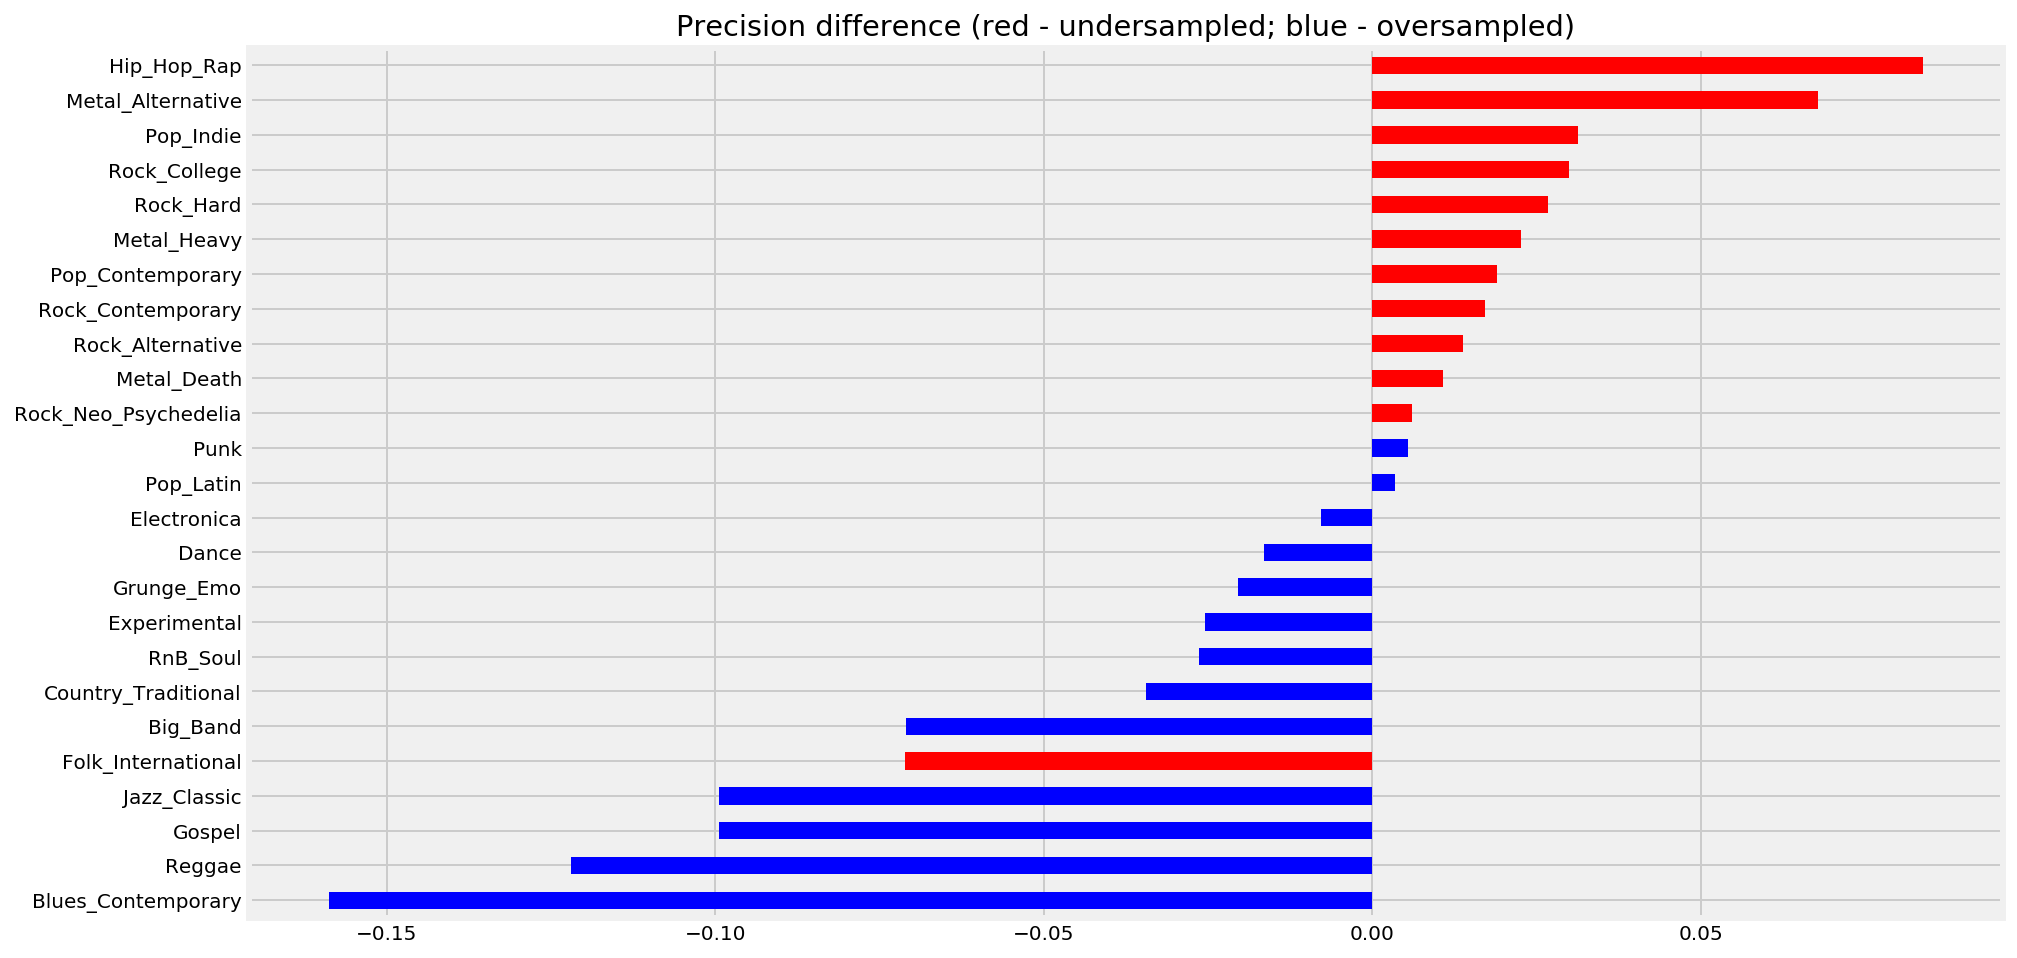

In [144]:
scores_df_short_precision = pd.DataFrame(
                                scores_df.drop(['precision_score', 'recall_score', 'precision_score_us',
                                               'recall_score_us', 'precision_diff_us', 'recall_diff_us',
                                               'precision_score_ms', 'recall_score_ms', 'recall_diff_ms'],
                                               axis=1),
                                         columns = ['precision_diff_ms'])

scores_df_short_precision.sort_values(by = 'precision_diff_ms').precision_diff_ms.plot(kind='barh', 
                                    color = ['b', 'b', 'b', 'b', 'r', 'b', 'b', 'b', 'b','b', 'b',
                                             'b', 'b', 'b', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r',
                                             'r', 'r', 'r' ],
                                    figsize = (14,8),
                                    title = 'Precision difference (red - undersampled; blue - oversampled)')
plt.show();

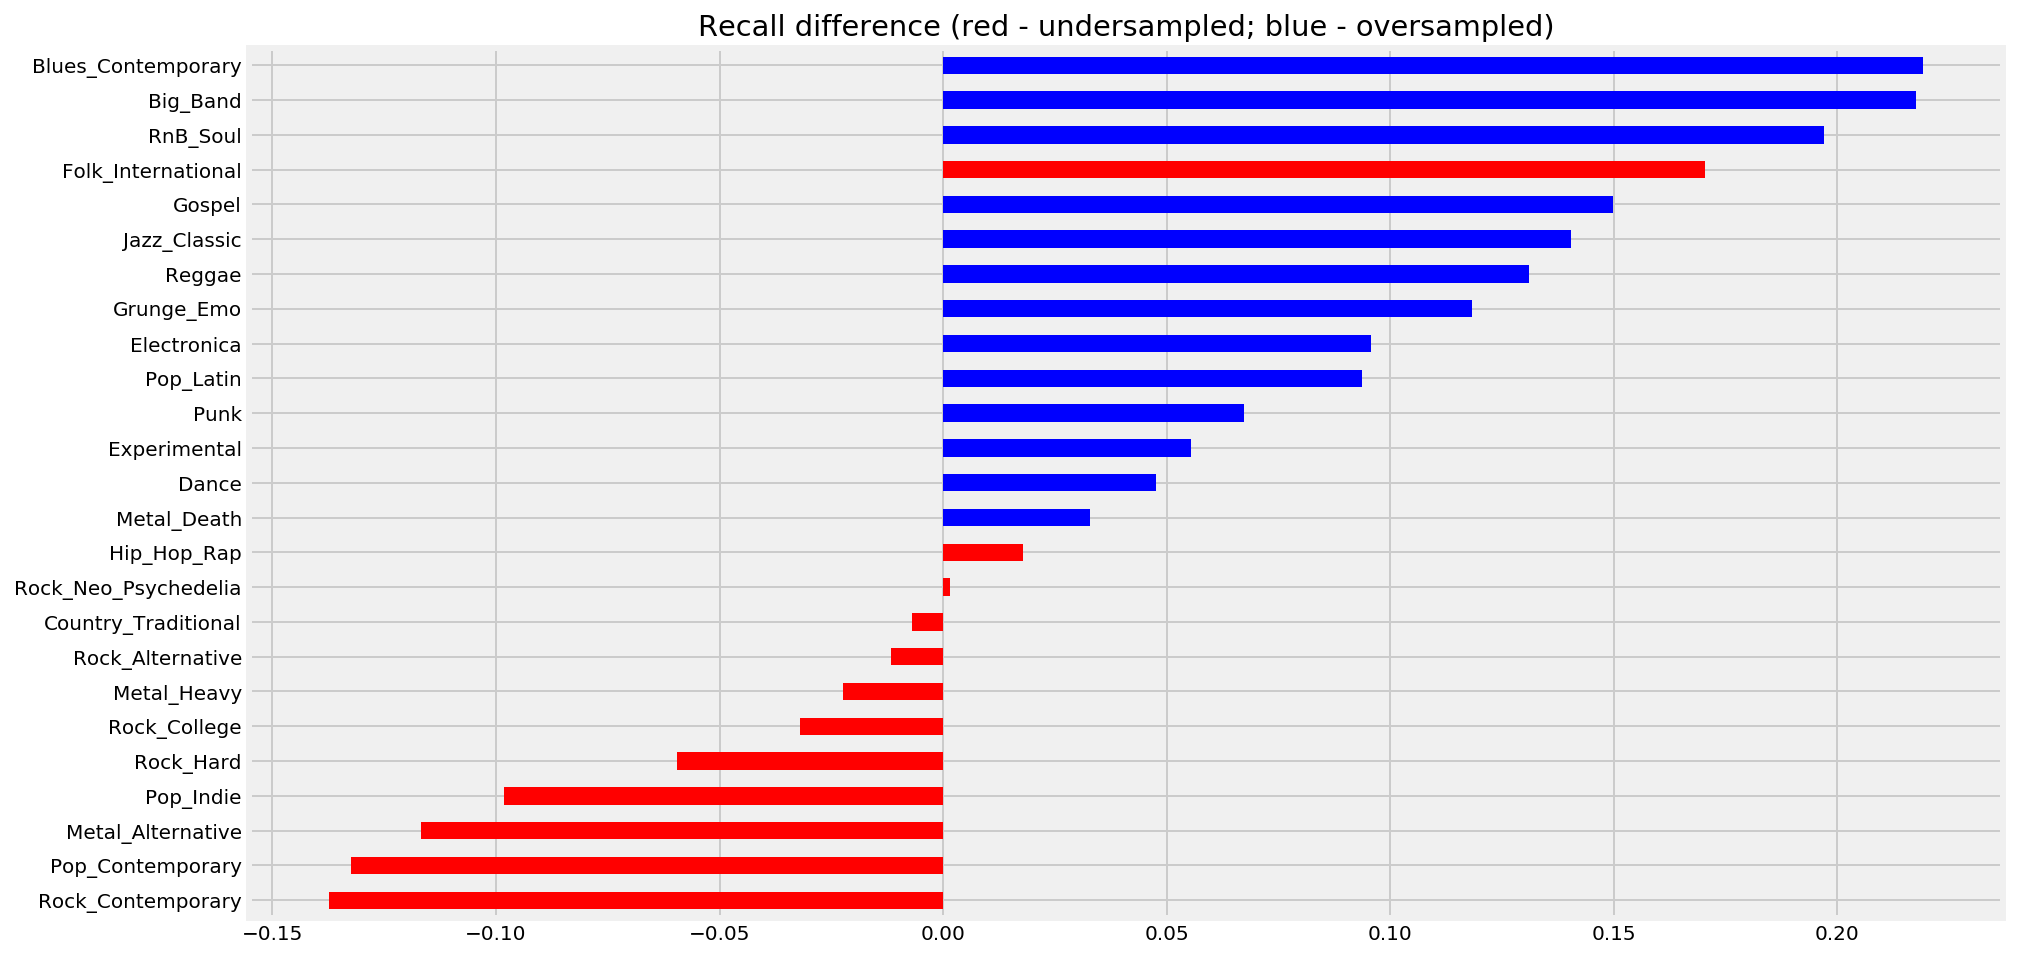

In [146]:
scores_df_short_recall = pd.DataFrame(
                            scores_df.drop(['precision_score', 'recall_score', 'precision_score_us',
                                           'recall_score_us', 'precision_diff_us', 'recall_diff_us',
                                           'precision_score_ms', 'recall_score_ms', 'precision_diff_ms'],
                                           axis=1),
                                      columns = ['recall_diff_ms'])

scores_df_short_recall.sort_values(by = 'recall_diff_ms').recall_diff_ms.plot(kind='barh', 
                                    color = ['r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r',
                                             'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b','b', 'r',
                                             'b', 'b', 'b'],
                                    figsize = (14,8),
                                    title = 'Recall difference (red - undersampled; blue - oversampled)')
plt.show();

For the above two graphs, red bars represent classes which were undersampled down to 3070 and blue bars represent classes which were oversampled to that same sample size. Note that the amount of samples 'gained' or 'lost' with the over - and undersampling varies greatly within each colour, as some labels started off with more observations and other less.

Apart from the obvious outlier of International folk music, the expectation of falling precision and rising recall for the classes that were oversampled holds true, as does the opposite for the undersampled classes. This means that we have successfully built a model that, with similar accuracy, is more sensitive to the classes that were previously under-represented in the dataset. 

Whether this model is an improvement on the one built on the original imbalanced dataset depends on one's belief in whether the equal distribution of song labels in the latter model is more in line with our expectaion of genre labels 'in the real world'.

<a id='tfidf'></a>

### Models with TFIDF

TFIDF, short for 'term frequency–inverse document frequency', is a numerical statistic used to reflect how important words are to a document in a corpus ("Data Mining", Rajaraman, A. and Ullman, J.D. (2011)).

This could potentially perform better than the previously used standard binary word presence indicator variables, as TFIDF gives weights to words that are specific to certain labels, thereby helping to highlight the importance of words that set some classes/genres apart from others.

The one potential issue here is that for TFIDF we would ideally like to have all lyrics across all songs, not just the top 5000.

NOTE: To run TFIDF, we need the actual word counts not just a binary indicator of whether certain words are present in songs or not. To achieve this, replace the 'then' statement in the 'Create a genres and bag-of-words lyrics dataframe by combining the above two' subsection of 'Data set-up and cleaning' as instructed above.

In [11]:
# Transform the train and test data to tfidf format
tfidf = TfidfTransformer()
x_train_tfidf = tfidf.fit_transform(x_train)
x_test_tfidf = tfidf.transform(x_test)

In [19]:
start_time = time.time()
model = LogisticRegression()
model.fit(x_train_tfidf, y_train)

print('Logistic regression:')
print(f'Cross-val. train score: {round(cross_val_score(model, x_train_tfidf, y_train, cv=3, n_jobs=-1)\
      .mean(), 4)}')
print(f'Test score: {round(model.score(x_test_tfidf, y_test), 4)}')
print(f'Time elapsed: {round((time.time() - start_time), 1)} seconds')

Logistic regression:
Cross-validated train score: 0.2872
Test score: 0.2952
Time elapsed: 81.4 seconds


Even without hyperparameter optimisation, TFIDF logistic regression improved both the cross-validated training scores and the test score when compared to the initial logistic regression model above.

<a id='merged'></a>

### Models with consolidated style labels

Because of the aforementioned problem that some of the genre labels are presumably rather similar to one another, both in how people perceive them and also where their respective misclassifications lie, it could make sense to merge some of these subgenres into larger ones. 

The most obvious examples here are five rock subgenres, which most people probably wouldn't be able to distinguish from one another, and where most of the misclassifications are made for other rock subgenres (see confusion matrix above)

In [6]:
# Mergings all rock genres under the 'Rock_Alternative' label and all metal genres under 
# the 'Metal_Alternative' label. Merging indie pop and contemporary pop could also be considered.

Y_string[(Y_string=='Rock_Neo_Psychedelia')] = 'Rock_Alternative'
Y_string[(Y_string=='Rock_Hard')] = 'Rock_Alternative'
Y_string[(Y_string=='Rock_Contemporary')] = 'Rock_Alternative'
Y_string[(Y_string=='Rock_College')] = 'Rock_Alternative'
Y_string[(Y_string=='Metal_Death')] = 'Metal_Alternative'
Y_string[(Y_string=='Metal_Heavy')] = 'Metal_Alternative'
# Y_string[(Y_string=='Pop_Indie')] = 'Pop_Contemporary'

le = LabelEncoder()
le.fit(['Punk', 'Pop_Indie', 'Hip_Hop_Rap', 'Country_Traditional', 'Pop_Contemporary', 
        'Rock_Alternative', 'Experimental', 'Metal_Alternative','RnB_Soul', 'Reggae', 
        'Folk_International', 'Pop_Latin','Grunge_Emo', 'Gospel', 'Electronica', 
        'Jazz_Classic', 'Dance', 'Blues_Contemporary', 'Big_Band'])
y = le.transform(Y_string)
x = test_df.copy().reset_index(drop = True)

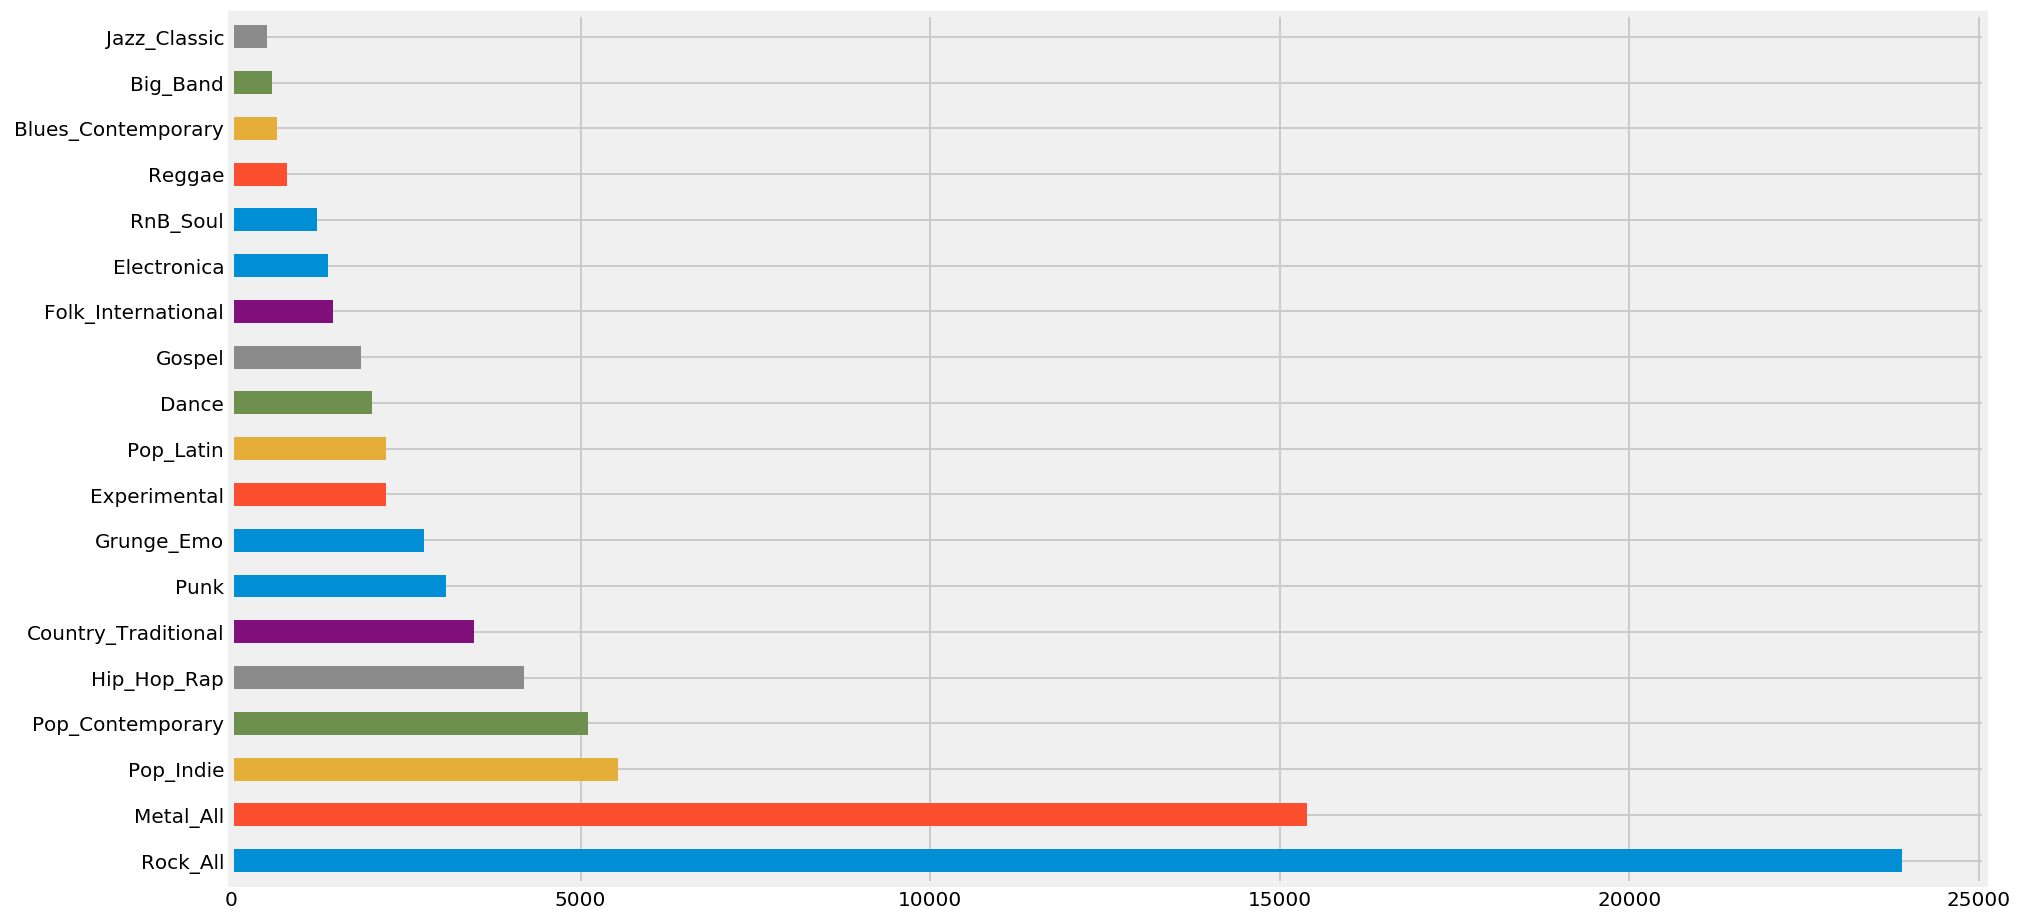

In [25]:
plt.figure(figsize=(14,8))
pd.Series(y_train).value_counts().plot(kind='barh')
plt.yticks(list(range(19)),
           list(reversed(le.inverse_transform([10,0,1,16,17,4,6,7,3,14,5,8,15,2,9,12,13,11,18]))))
plt.show();

The distribution has become even more imbalanced now that rock and metal genres have been merged.

##### Models with imbalanced data (consolidated genres)

In [4]:
print(f'New baseline accuracy: {(round(len(y_train[y_train==18])/len(y_train), 4))}')

New baseline accuracy: 0.305


In [9]:
# Transform the train and test data to tfidf format
tfidf = TfidfTransformer()
x_train_tfidf = tfidf.fit_transform(x_train)
x_test_tfidf = tfidf.transform(x_test)

In [14]:
start_time = time.time()
model = LogisticRegression()
model.fit(x_train_tfidf, y_train)

print('Logistic regression:')
print(f'Cross-val. train score: {round(cross_val_score(model, x_train_tfidf, y_train, cv=3, n_jobs=-1)\
      .mean(), 4)}')
print(f'Test score: {round(model.score(x_test_tfidf, y_test), 4)}')
print(f'Time elapsed: {round((time.time() - start_time), 1)} seconds')

Logistic regression:
Cross-validated train score: 0.4469
Test score: 0.4463
Time elapsed: 72.6 seconds


These models are, as expected, performing much better. Of course, the baseline is now considerably higher as well. Therefore, if distinguishing the various metal and rock subgenres is not beneficial to the user of the model, then these models might be preferable to the original ones above. However, obviously comes at the expense of being able to tell apart various rock and metal subgenre songs from one another.

##### Models with data rebalanced by undersampling (consolidated genres)

The problem of class imbalance is now even more stark. To counter that, the classes could, like above, be resampled in order to make the minority classes more pertinent.

In [10]:
# Specify labels which will be pushed down to 3070
us_labels = {18:5534, 
             11:5534}

# Perform the undersampling for the abovementioned classes
sampler = RandomUnderSampler(random_state = 1, ratio = us_labels)
x_train_us, y_train_us = sampler.fit_sample(x_train, y_train)

In [13]:
tfidf = TfidfTransformer()
x_train_us_tfidf = tfidf.fit_transform(x_train_us)
x_test_tfidf = tfidf.fit_transform(x_test)

In [14]:
print(f'New baseline accuracy: {(round(len(y_train_us[y_train_us==18])/len(y_train_us), 4))}')

New baseline accuracy: 0.1104


In [15]:
start_time = time.time()
model = LogisticRegression()
model.fit(x_train_us_tfidf, y_train_us)

print('Logistic regression:')
print(f'Cross-val. train score: {round(cross_val_score(model, x_train_us_tfidf, y_train_us, cv=3, n_jobs=-1)\
      .mean(), 4)}')
print(f'Test score: {round(model.score(x_test_tfidf, y_test), 4)}')
print(f'Time elapsed: {round((time.time() - start_time), 1)} seconds')

Logistic regression:
Cross-validated train score: 0.3536
Test score: 0.3468
Time elapsed: 26.9 seconds


<a id='grid'></a>

### Hyperparameter optimisation for the final model

Choosing the most appropriate dataset for the final model from the above transformations will be largely subjective. Although the accuracy increase in the case of consolidated rock and metal subgenres could be justifiable in cases where we don't deem this distinction to be important, there are certainly also other cases where these distinctions would be informative or even vital.

Here, I will be choosing the TFIDF data with consolidated metal and rock labels, as models on this data achieved the best results, and I am not interested in telling apart rock and metal genres to such a granular level.

The models that initially after hyperparameter optimisation performed best were logistic regression, XGBoost classifier and MLP. The hyperparameters for these three algorithms will be fine-tuned below, however this time using the consolidated TFIDF data.

##### Logistic Regression CV Gridsearch

In [14]:
start_time = time.time()

model = LogisticRegression()

# setup the grid search
params = {'C':np.logspace(-3,3,20)}

gs = GridSearchCV(estimator=model,
                  param_grid=params,
                  cv=3,
                  scoring='accuracy',
                  return_train_score=True,
                  n_jobs = -1)

gs.fit(x_train_tfidf, y_train)

# extract the grid search results
print('Best Parameters:')
print(gs.best_params_)
print('Best estimator mean cross validated training score:')
print(gs.best_score_)
print('Best estimator score on the full training set:')
print(gs.score(x_train_tfidf, y_train))
print('Best estimator score on the test set:')
print(gs.score(x_test_tfidf, y_test))
print(f'Time elapsed: {round((time.time() - start_time)/60)} minutes')

Best Parameters:
{'C': 1.438449888287663}
Best estimator mean cross validated training score:
0.447125204248366
Best estimator score on the full training set:
0.4881535947712418
Best estimator score on the test set:
0.448167579366599
Time elapsed: 28 minutes


##### XGBoost Gridsearch

In [13]:
start_time = time.time()

model = XGBClassifier()

# setup the grid search
params = {
        'learning_rate':[0.1, 0.3],
        'min_child_weight':[1, 5, 10],
        'max_depth':[3, 5, 10]
        }

gs = GridSearchCV(estimator=model,
                  param_grid=params,
                  cv=3,
                  scoring='accuracy',
                  return_train_score=True,
                  n_jobs = -1)

gs.fit(x_train_tfidf, y_train)

# extract the grid search results
print('Best Parameters:')
print(gs.best_params_)
print('Best estimator mean cross validated training score:')
print(gs.best_score_)
print('Best estimator score on the full training set:')
print(gs.score(x_train_tfidf, y_train))
print('Best estimator score on the test set:')
print(gs.score(x_test_tfidf, y_test))
print(f'Time elapsed: {round((time.time() - start_time)/60)} minutes')

Best Parameters:
{'learning_rate': 0.1, 'max_depth': 10, 'min_child_weight': 10}
Best estimator mean cross validated training score:
0.4452359068627451
Best estimator score on the full training set:
0.6129748774509803
Best estimator score on the test set:
0.44920154712212307
Time elapsed: 293 minutes


##### Neural networks: multi-layer perceptron classifier

In [ ]:
start_time = time.time()

model = MLPClassifier()

# setup the grid search
params = {
        'hidden_layer_sizes': [(50,50), (100,)],
        'activation': ['tanh', 'relu'],
        'solver': ['sgd', 'adam'],
        'alpha': [0.0001, 0.05]
        }

gs = GridSearchCV(estimator=model,
                  param_grid=params,
                  cv=3,
                  scoring='accuracy',
                  return_train_score=True,
                  n_jobs = -1)

gs.fit(x_train_sparse, y_train)

# extract the grid search results
print('Best Parameters:')
print(gs.best_params_)
print('Best estimator mean cross validated training score:')
print(gs.best_score_)
print('Best estimator score on the full training set:')
print(gs.score(x_train_sparse, y_train))
print('Best estimator score on the test set:')
print(gs.score(x_test_sparse, y_test))
print(f'Time elapsed: {round((time.time() - start_time)/60)} minutes')

Logistic regression still (narrowly) outperforms the other two models here, so it will be used as the final model for genre predictions at:<br>
http://ec2-52-14-243-207.us-east-2.compute.amazonaws.com/

<a id='pca'></a>

### Dimensionality reduction and clustering

##### PCA

To employ various clustering techniques on data of this size, it would be helpful or even necessary to use principal component analysis (PCA) to reduce the amount of variables we're dealing with

In [39]:
# Standardising the trining dataframe and fitting it to PCA (principal component analysis)
scaler = StandardScaler()
x_train_ss = pd.DataFrame(scaler.fit_transform(x_train), columns = x_train.columns)
x_train_pca = PCA(n_components = 50)
x_train_pca.fit(x_train_ss);

In [40]:
np.round(np.cumsum(x_train_pca.explained_variance_ratio_), 3)

array([0.012, 0.022, 0.029, 0.036, 0.042, 0.046, 0.05 , 0.053, 0.055,
       0.058, 0.059, 0.061, 0.062, 0.063, 0.064, 0.065, 0.066, 0.067,
       0.068, 0.068, 0.069, 0.07 , 0.071, 0.071, 0.072, 0.073, 0.074,
       0.074, 0.075, 0.076, 0.076, 0.077, 0.077, 0.078, 0.079, 0.079,
       0.08 , 0.08 , 0.081, 0.081, 0.082, 0.082, 0.083, 0.083, 0.084,
       0.084, 0.085, 0.085, 0.086, 0.086])

Looks like dimensionality reduction might not be very useful given that even 50 variables explain less than 10% of the variance in the data. A number of clustering algorithms were tried (including DBScan and Hierarchical clustering), yet due to the amount of features present without successful PCA, these tasks turned out to be too resource intensive to calculate.

Instead, Latent Dirichlet Allocation (https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation) will be used below:

##### Latent Dirichlet Allocation

In [21]:
# Remove stop-word columns
tvec = TfidfVectorizer(stop_words='english')
stopwords = list(tvec.get_stop_words())
ignore_extra = ['know', 'just', 'like', 'say']

for word in ignore_extra:
    stopwords.append(word)
x = x[[col for col in x.columns if col not in stopwords]]

# Turn x to sparse matrix
x_sparse = sp.sparse.csr_matrix(x.values)

In [106]:
# Fit the sparse X matrix onto the LDA
lda = LatentDirichletAllocation(n_components = 6, random_state=2)
lda.fit(x_sparse);

In [107]:
# Transform the sparse matrix into class allocation predictions
doc_topic_dist_unnormalized = np.matrix(lda.transform(x_sparse))
doc_topic_dist = doc_topic_dist_unnormalized / doc_topic_dist_unnormalized.sum(axis = 1)

In [108]:
# Put the above predictions in a dataframe, adding another column for the actual genre labels
doc_topic_df = pd.DataFrame(doc_topic_dist.argmax(axis=1), columns = ['lda_pred'])
doc_topic_df['real'] = y

le = LabelEncoder()
le.fit(['Punk', 'Pop_Indie', 'Hip_Hop_Rap', 'Country_Traditional', 'Pop_Contemporary', 
        'Rock_Alternative', 'Rock_College', 'Rock_Contemporary', 'Experimental', 
        'Metal_Alternative','RnB_Soul', 'Reggae', 'Folk_International', 'Pop_Latin', 
        'Metal_Heavy', 'Rock_Neo_Psychedelia', 'Grunge_Emo', 'Rock_Hard', 'Gospel', 
        'Electronica', 'Metal_Death', 'Jazz_Classic', 'Dance', 'Blues_Contemporary', 'Big_Band'])

doc_topic_df['real_genre'] = le.inverse_transform(doc_topic_df.real)
doc_topic_df.drop('real', axis=1, inplace=True)

In [26]:
#OPTIONAL 

# write pickle
doc_topic_df.to_pickle("./doc_topic_df.pkl")
# read pickle
doc_topic_df = pd.read_pickle("./doc_topic_df.pkl")

In [25]:
doc_topic_df.head(3)

,lda_pred,real_genre
0,4,Punk
1,4,Pop_Indie
2,3,Pop_Indie


In [96]:
#function to display the top n words in an identified topic
def display_topics(model, feature_names, no_top_words):
   # cycle through identified topic
    topic_counter = 0
    for topic_idx, topic in enumerate(lda.components_):
        print("Topic %d:" % (topic_idx))
        print("\n")
        print(f'Top 3 genres within this topic:\n
              {doc_topic_df[doc_topic_df.lda_pred == topic_counter].real_genre.value_counts()[:3]}')
        #print the top words per topic as a comma separated string
        print("\n")
        print(", ".join([
           feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]
                        ]))
        print("-------------------------------------------------------------------------------------")
        topic_counter += 1

In [109]:
# Display the top 15 words for each of the identified topics
no_top_words = 15
display_topics(lda, feature_names, no_top_words)

Topic 0:


Top 3 genres within this topic:
Pop_Latin             2774
Folk_International     885
Pop_Contemporary       715
Name: real_genre, dtype: int64


la, que, en, se, y, te, tu, mi, el, si, lo, por, es, yo, una
----------------------------------------------------------------------------------------------
Topic 1:


Top 3 genres within this topic:
Folk_International    235
Rock_Contemporary     159
Pop_Contemporary      155
Name: real_genre, dtype: int64


die, und, den, im, der, du, ich, das, nicht, ist, ein, whenev, es, dem, zu
----------------------------------------------------------------------------------------------
Topic 2:


Top 3 genres within this topic:
Hip_Hop_Rap          3122
Rock_Hard             574
Metal_Alternative     482
Name: real_genre, dtype: int64


got, man, shit, caus, yeah, ya, gonna, make, fuck, ai, let, wanna, em, gotta, hit
----------------------------------------------------------------------------------------------
Topic 3:


Top 3 genres within t

Latent Dirichlet allocation has proven to be rather good at identifying common themes among songs. Looking at the first group of songs, it has labelled together the 'international' songs belonging primarily to the Latin pop and international folk genres. Looking at topic 2, it has succeeded in catching most of the hip-hop/rap songs. The abovementioned common themes among various metal genres have seemingly been the primary driver behind the allocation of topic 3.  

These allocations and/or clustering could be used in the future to create novel genre groupings of songs based purely on their lyrical content.

 <a id='theend'></a>

## Conclusions: findings and limitations

The purpose of this project was to examine whether songs' lyrics are a good predictor of their genres. Given the dataset, it was going to be a difficult task. The main difficulty arises from the fact that the original dataset has 25 genre labels. Some of those genres tend to be very distinct from one another, however, other are also very similar to one another in their lyrical content, being subgenres of a larger one (e.g. the five very similar sub-genres of rock music). Thus, this lack of clear-cut classes, combined with the large number of possible classification labels, makes it inherently very difficult to build a highly accurate model.

However, I was nevertheless able to build models that performed reasonably well, more than tripling the original accuracy of the baseline of around 0.083. Looking at the logistic regression model (not resampled), the model built is rather good at predicting latin pop songs and hip-hop/rap songs, with precision and recall scores of over 0.6 for both of them. The former is very clearly easy to distinguish due to it being the only genre with predominantly non-English lyrics. Hip-hop songs are likely distinguishable due to their famously unique and comprehensive vocabularies, as well as the use of profanities highlighted by the most pertinent words in the relevant LDA group above.

However, due to the relatively low precision scores for other classes, predictions for them should be taken with a pinch of salt. The misclassifications aren't however, for the most part, as bad as they seem, with a very large proportion of them being made for similar classes. Most notably, across all five rock sub-genres, most misclassifications are made for other rock classes. As there is, as previously mentioned, a lot of overlap and a lack of clear distinction in case of these related sub-genres, many of these misclassifications might be acceptable to users of the model, being 'close enough'.

These models could likely hbe greatly improved by introducing some additional variables about the songs available in the Million Song Dataset, like the key the song is in, its loudness, tempo or length. It could also have been very useful to have access to the original lyrics data, to see if using n-grams rather than simple binary single word counters could have improved the performance of the models.

If one were interested in predicting whether a song belongs to certain genres or not, the dataset at hand could easily be altered to simply make a binary prediction about whether a song belongs to a certain genre (e.g. hip-hop vs. rock) or not.

Finally, the real-life applicability of the model could likely be improved by using a dataset which better reflects the expected genre distribution of contemporary music. As mentioned above, such a dataset would, for example, have a much higher proportion of R&B and hip-hop/rap songs that the dataset at hand.